In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from fastapi import FastAPI 
import uvicorn

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
RGB_channels = 3
EPOCH = 50

In [3]:
datesets = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\gniew\\Desktop\\Python\\Code_basic\\potato\\PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name = datesets.class_names

In [5]:
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

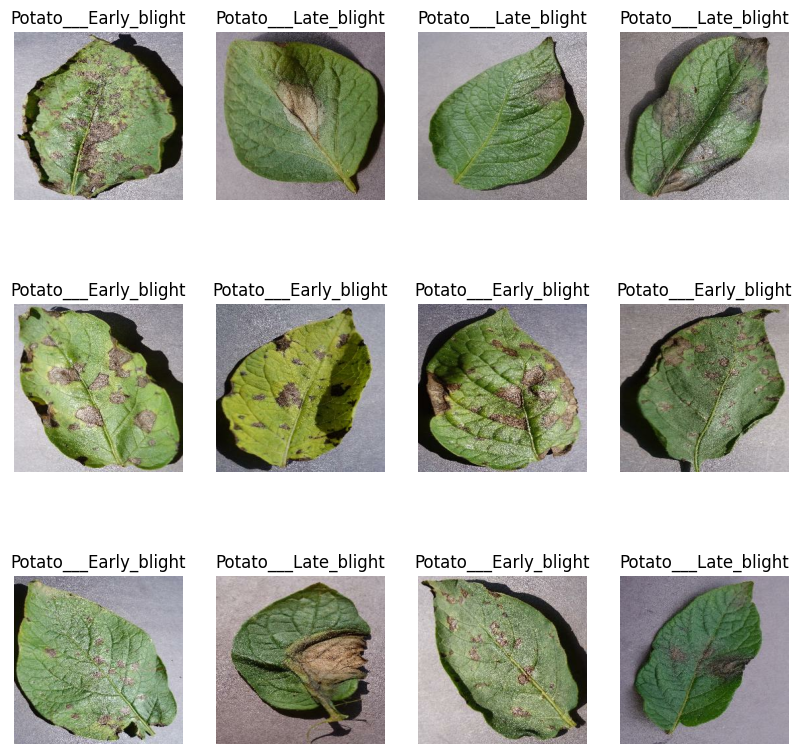

In [6]:
plt.figure(figsize = (10,10))
for image_batch, image_label in datesets.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[image_label[i]])
        plt.axis("off")

In [7]:
def split_data_train_test_validate(ds, training_split = 0.8, test_split = 0.1, validate_split = 0.1, shuffle = True, shuffle_size = 10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    ds_size = len(ds)
    ds_training = int(ds_size * training_split)
    ds_test = int(ds_size * test_split)
    train_ds = ds.take(ds_training)
    val_ds = ds.skip(ds_training).take(ds_test)
    test_ds = ds.skip(ds_training).skip(ds_test)
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = split_data_train_test_validate(datesets)

In [9]:
len(train_ds)

54

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [12]:
data_agumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE , IMAGE_SIZE, RGB_channels)
model = models.Sequential([
    resize_rescale,
    data_agumentation,
    layers.Conv2D(32, (3,3), activation = "relu", input_shape =  input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation = "relu"),
    layers.Dense(len(class_name), activation = "softmax"),
    
])

model.build(input_shape =  input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
             )

In [16]:
history = model.fit(train_ds, epochs =EPOCH, batch_size = BATCH_SIZE,verbose = 1, validation_data =  val_ds)

Epoch 1/50
54/54 [==============================] - 20s 189ms/step - loss: 0.9322 - accuracy: 0.4711 - val_loss: 0.9117 - val_accuracy: 0.5104
Epoch 2/50
54/54 [==============================] - 8s 145ms/step - loss: 0.8795 - accuracy: 0.5041 - val_loss: 0.8659 - val_accuracy: 0.4531
Epoch 3/50
54/54 [==============================] - 8s 145ms/step - loss: 0.7459 - accuracy: 0.6192 - val_loss: 0.6559 - val_accuracy: 0.7135
Epoch 4/50
54/54 [==============================] - 8s 141ms/step - loss: 0.5863 - accuracy: 0.7541 - val_loss: 0.8359 - val_accuracy: 0.5677
Epoch 5/50
54/54 [==============================] - 8s 142ms/step - loss: 0.5003 - accuracy: 0.7899 - val_loss: 0.5934 - val_accuracy: 0.6927
Epoch 6/50
54/54 [==============================] - 8s 144ms/step - loss: 0.3866 - accuracy: 0.8397 - val_loss: 0.3159 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 8s 141ms/step - loss: 0.3109 - accuracy: 0.8773 - val_loss: 0.2384 - val_accuracy: 0.8802
Epoch

In [17]:
scores =  model.evaluate(test_ds)

8/8 [==============================] - 1s 21ms/step - loss: 0.0614 - accuracy: 0.9844


In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
history.history['accuracy']

[0.47106480598449707,
 0.5040509104728699,
 0.6192129850387573,
 0.7540509104728699,
 0.7899305820465088,
 0.8396990895271301,
 0.8773148059844971,
 0.9230324029922485,
 0.9212962985038757,
 0.9421296119689941,
 0.9548611044883728,
 0.9623842835426331,
 0.9560185074806213,
 0.9693287014961243,
 0.9739583134651184,
 0.9652777910232544,
 0.9832175970077515,
 0.9722222089767456,
 0.9722222089767456,
 0.984375,
 0.9756944179534912,
 0.9890046119689941,
 0.9849537014961243,
 0.9866898059844971,
 0.9594907164573669,
 0.9878472089767456,
 0.9895833134651184,
 0.9936342835426331,
 0.9768518805503845,
 0.9837962985038757,
 0.9716435074806213,
 0.9913194179534912,
 0.9837962985038757,
 0.9814814925193787,
 0.9895833134651184,
 0.9890046119689941,
 0.9907407164573669,
 0.9988425970077515,
 0.9814814925193787,
 0.9884259104728699,
 0.9971064925193787,
 0.9965277910232544,
 0.9924768805503845,
 0.9965277910232544,
 0.9942129850387573,
 0.9890046119689941,
 0.9913194179534912,
 0.9982638955116272,
 

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


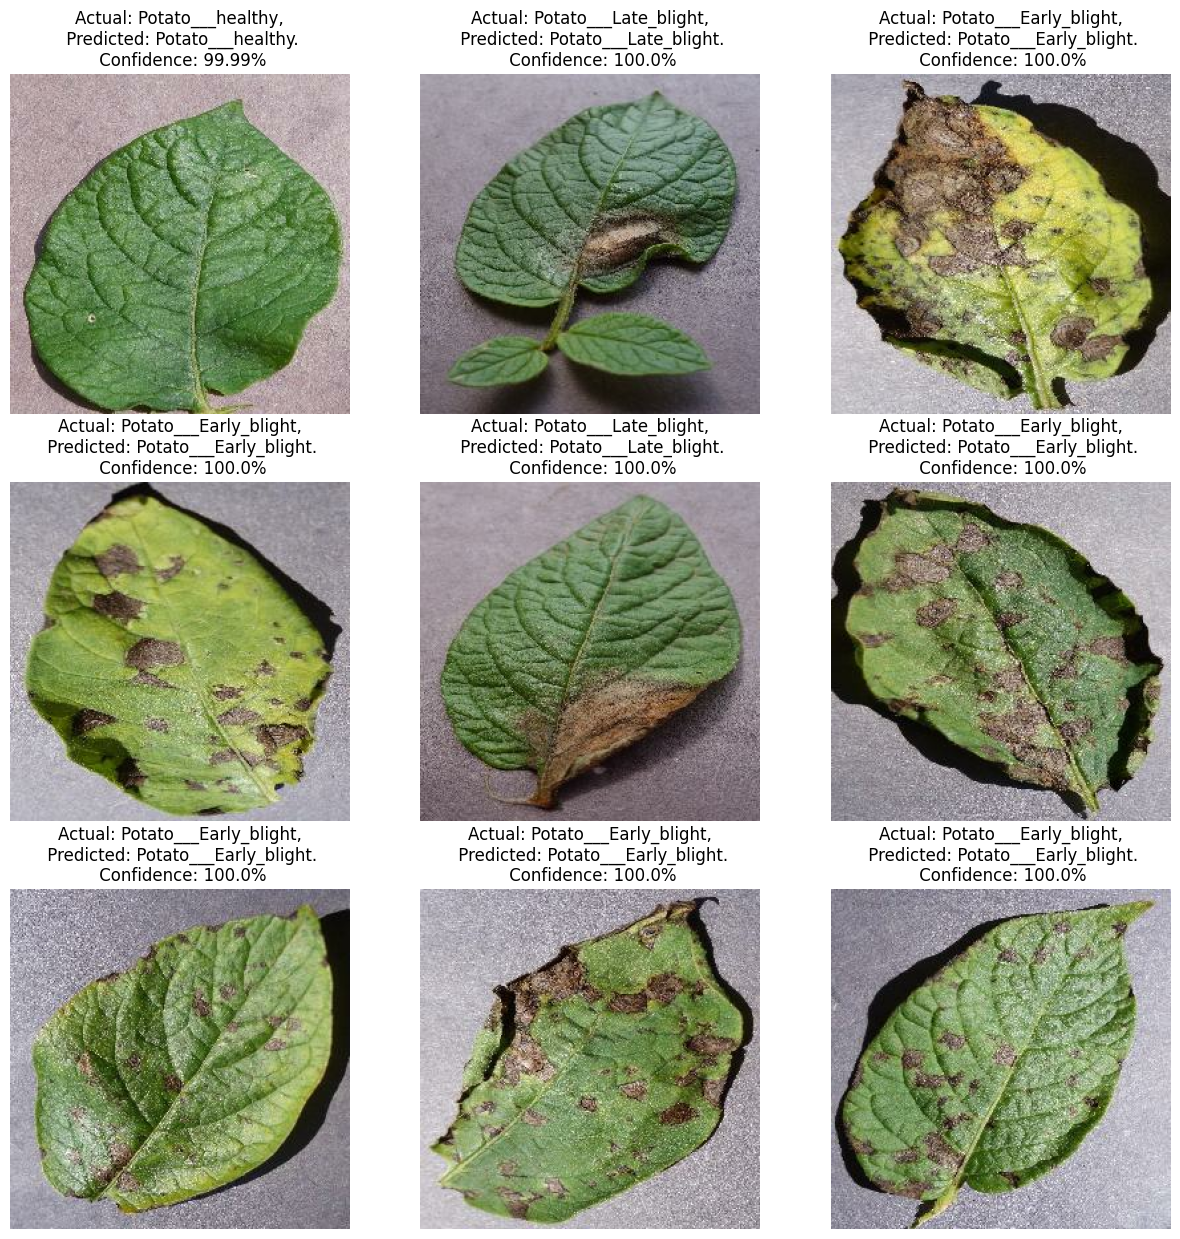

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [39]:
model_version = "last_2"

In [40]:
model.save(f"C:\\Users\\gniew\\Desktop\\Python\\Code_basic\\potato\model\\{model_version}")

INFO:tensorflow:Assets written to: C:\Users\gniew\Desktop\Python\Code_basic\potato\model\last_2\assets


INFO:tensorflow:Assets written to: C:\Users\gniew\Desktop\Python\Code_basic\potato\model\last_2\assets
